### Add model, connection and device to settings:

In [12]:
# библиотеки
import os
import sys
import inspect
import numpy as np
import re
import math
import matplotlib.pyplot as plt
from ipywidgets import interactive
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
from hybriddomain.envs.hs.model.model_main import ModelNet as Model
from hybriddomain.settings.settings_main import Settings
from ddeint import ddeint

# пути и названия файлов
modelFileName = 'problems/hutchinson_equation'
conn_name = "connection.json"
device_conf_name = "devices.json"

#Ввод пароля для инициализации пользователя
model = Model()
model.io.loadFromFile(modelFileName)
settings = Settings(model, conn_name, device_conf_name, conn_name)

INFO:settings_main:device_conf_rpath
INFO:settings_main:devices.json


Please enter password for user imaslenikov:


 ·········


In [13]:
print("equations:")
print(model.equations)
print("params:")
print(model.params)
print("paramValues:")
print(model.paramValues)

equations:
[["U'= a*(1-U(t-1)/b)*U"]]
params:
['a', 'b']
paramValues:
[{'a': 1, 'b': 1}, {'a': 2, 'b': 2}, {'a': 3, 'b': 5}, {'a': 4, 'b': 20}, {'a': 3, 'b': 100}]


### Run solver:

In [14]:
# запуск процесса решения уравнения
from hybriddomain.solvers.hs.remoterun.progresses.progress_notebook import ProgressNotebook
from hybriddomain.solvers.hs.postproc.results.results_main import ResultPostprocNet as ResultPostproc
progress = ProgressNotebook(100, prefix='solving')

progress_params = ProgressNotebook(len(model.paramValues), prefix='param')
# display(progress_params.progress)

progress_solving = ProgressNotebook(100, prefix='solving')
# display(progress_solving.progress)
# progress_solving.succ(0)

result_postproc = ResultPostproc(modelFileName)

from hybriddomain.solvers.hs.remoterun.remoterun import remoteProjectRun

clear_output()
test_name = settings.paths['model']['name']
bTest = widgets.Button(description="run %s " % (test_name))

# parametrisation:
def run(event):
    model = Model()
    model.io.loadFromFile(modelFileName)
    
    for params_idx in range(len(model.paramValues)):
        
        progress_params.succ(params_idx)
        progress_solving.set_prefix("solving")
        
        # changing param:
        model.defaultParamsIndex = params_idx
        model.io.saveToFile(settings.paths["hd"]["json"])
        model = Model()
        model.io.loadFromFile(modelFileName)
        
        remoteProjectRun(settings, 1, progress_solving,remove_old=False)
        
        # result_postproc.extract_out(params_idx, results_params)
        result_postproc.rename_out(params_idx)
    display(Javascript("alert('Done');"))
    
bTest.on_click(run)

display(progress_params.progress)
display(progress_solving.progress)
 
display(bTest)

IntProgress(value=0, description='param: ', max=4)

IntProgress(value=0, description='solving: ', max=99)

Button(description='run hutchinson_equation ', style=ButtonStyle())

### Results:

In [15]:
model.readResults(result_format=1)
# available result files:
print("result files: ", model.results_paths)
# available plot files:
print("plot files: ", model.plots_paths)

result files:  {'U': ['problems/hutchinson_equation/out/U_seq0.out', 'problems/hutchinson_equation/out/U_seq1.out', 'problems/hutchinson_equation/out/U_seq2.out', 'problems/hutchinson_equation/out/U_seq3.out', 'problems/hutchinson_equation/out/U_seq4.out']}
plot files:  {'U': ['problems/hutchinson_equation/out/U_seq0.mp4', 'problems/hutchinson_equation/out/U_seq1.mp4', 'problems/hutchinson_equation/out/U_seq2.mp4', 'problems/hutchinson_equation/out/U_seq3.mp4', 'problems/hutchinson_equation/out/U_seq4.mp4']}


In [16]:
# объекте model хранится вся информация по решению задачи
# get results (for TRAC-11 result_format=1):
model.readResults(result_format=1)
model.results_paths
# available results:
print(model.results_arrays.keys())

dict_keys(['U'])


### Video:

In [17]:
# available plots:
model.plots_paths

{'U': ['problems/hutchinson_equation/out/U_seq0.mp4',
  'problems/hutchinson_equation/out/U_seq1.mp4',
  'problems/hutchinson_equation/out/U_seq2.mp4',
  'problems/hutchinson_equation/out/U_seq3.mp4',
  'problems/hutchinson_equation/out/U_seq4.mp4']}

In [18]:
display(HTML(model.get_video('U')))
display(HTML(model.get_video('U',1)))
display(HTML(model.get_video('U',2)))
display(HTML(model.get_video('U',3)))
display(HTML(model.get_video('U',4)))

### U(x, t-fixed),V(x, t-fixed):

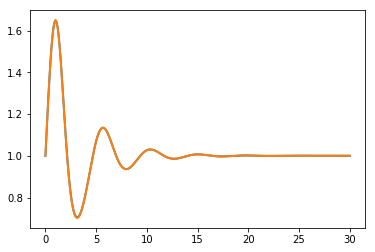

In [20]:
# отрисовывает результат
%matplotlib inline
time = model.results_arrays['U']['timevalues']

times = model.results_arrays['U']['timevalues']

result = model.results_arrays['U']['resvalues']
#print(result)
result_x = np.array([result[time][0][0] for time in times])
plt.plot(time, result_x, lw=2)


b = 1
h = 1
a = 1

def model1(Y,t,d):
    y=Y(t)
    yd=Y(t-h)
    return np.array([a * (1 - ( yd/b)) * y])
g=lambda t : t+1

#model1 = lambda Y,t, k,h,r :  a * (1 - ( Y(t-h)/b)) * Y(t)
#g = lambda t: t+1 # history before t=0
tt = np.linspace(0,30,30001)
for d in [0,0.2]:
    answer_DDE = ddeint(model1, g, tt, fargs=(d,)) # K=0.1, d=5, r=1
plt.plot(tt, answer_DDE, lw=2)
plt.show()


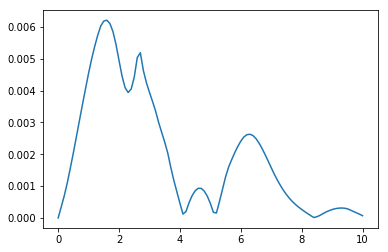

In [10]:
# отрисовывает отклонение нашего решения от решения DDE
%matplotlib inline

time = model.results_arrays['U']['timevalues']
times = model.results_arrays['U']['timevalues']
result = model.results_arrays['U']['resvalues']

result_x = np.array([result[time][0][0] for time in times])
b = 2
h = 1
a = 1

def model1(Y,t,d):
    y=Y(t)
    yd=Y(t-h)
    return np.array([a * (1 - ( yd/b)) * y])
g=lambda t : t+1

#количество точек для использования построения решения
tt =np.linspace (0.0,10.0,10001)
for d in [0,0.2]:
    answer_DDE = ddeint (model1,g,tt,fargs=(d,))
#print(time)
i = 0
find_error = []
for poi in time:
    b = abs(answer_DDE[i*100]-result_x[i])
    find_error.append(b)
    i+=1
plt.plot(time, find_error)


plt.show()


#Показать в явном виде разницу между результатами
#i = 0
#for poi in time:
#    print(answer_DDE[i*10,0],result_x[i])
#    i+=1